In [1]:
import numpy as np
import numpyro
from jax import random
from numpyro.infer import MCMC, HMC,NUTS
import fitsio
from multiprocessing import Pool
from astropy.table import Table
from astropy.io import fits
import fitsio
import jax.numpy as jnp
import matplotlib.pyplot as plt
from numpyro import handlers 
from jax import random, jit
import jax
import numpyro.distributions as dist
import fitting4
from astropy.cosmology import Planck18

In [2]:
array = np.array([1,2,3])
array1 = np.array([1,2,3,4])
array2 = np.array([1,2,3,4,5])
array1 = array1[:,None]
array2 = array2[:,None,None]
print((array+array1+array2).shape)
print()

(5, 4, 3)



In [3]:
# Verify the installation
print("JAX version:", jax.__version__)
print("JAX is using CUDA:", jax.lib.xla_bridge.get_backend().platform)

# Enable 64-bit floating point precision
jax.config.update("jax_enable_x64", True)

# Verify the update
print("jax_enable_x64:", jax.config.read("jax_enable_x64"))

JAX version: 0.4.30
JAX is using CUDA: gpu
jax_enable_x64: True


In [4]:
# Check available devices
print("Available devices:", jax.devices())

# Simple CPU computation test
x = jnp.array([1.0, 2.0, 3.0])
y = jax.device_put(x, jax.devices('gpu')[0])
z = y ** 2
print("Computation result:", z)

Available devices: [cuda(id=0)]
Computation result: [1. 4. 9.]


In [5]:
k = Table.read('/pscratch/sd/z/zhaozhon/DATASET/DESI-data/k1.csv',format='csv')
indice = np.isnan(k['k_rr']) | np.isinf(k['k_rr'])
#k_gg = k['k_gg'][~indice]
k_rr = k['k_rr'][~indice]

In [6]:
file = '/pscratch/sd/z/zhaozhon/DATASET/DESI-data/new_d.fits'
d = Table(fitsio.read(file))
SEL = np.where((d['Z'] > 2.3) & (d['Z'] < 2.8))[0]
TARGETID = d['TARGETID'][SEL][~indice]
#apr_mag_g = d['APP_MAG_G'][SEL][~indice]
#apr_mag_g_err = d['APP_MAGERR_G'][SEL][~indice]
apr_mag_r = d['APP_MAG_R'][SEL][~indice]
apr_mag_r_err = d['APP_MAGERR_R'][SEL][~indice]
z_desi = d['Z'][SEL][~indice]

In [7]:
d_desi = Planck18.distmod(z_desi).value

In [8]:
TARGETID, indices = np.unique(TARGETID, return_index=True)
#apr_mag_g = apr_mag_g[indices]
#apr_mag_g_err = apr_mag_g_err[indices]
apr_mag_r = apr_mag_r[indices]
apr_mag_r_err = apr_mag_r_err[indices]
d_desi = d_desi[indices]
z_desi = z_desi[indices]
#k_gg = k_gg[indices]
k_rr = k_rr[indices]

In [9]:
# Assuming z_desi is your redshift array
filter_mask = (z_desi > 2.3) & (z_desi < 2.6)

# Apply the filter to all arrays
TARGETID = TARGETID[filter_mask]
#apr_mag_g = apr_mag_g[filter_mask]
#apr_mag_g_err = apr_mag_g_err[filter_mask]
apr_mag_r = apr_mag_r[filter_mask]
apr_mag_r_err = apr_mag_r_err[filter_mask]
d_desi = d_desi[filter_mask]
z_desi = z_desi[filter_mask]
#k_gg = k_gg[filter_mask]
k_rr = k_rr[filter_mask]

# Recalculate N_obs after filtering
N_obs = TARGETID.shape[0]
print(N_obs)

9885


In [10]:
#apr_mag_g = apr_mag_g.astype(np.float64)
#apr_mag_g_err = apr_mag_g_err.astype(np.float64)
#k_gg = k_gg.astype(np.float64)

apr_mag_r = apr_mag_r.astype(np.float64)
apr_mag_r_err = apr_mag_r_err.astype(np.float64)
k_rr = k_rr.astype(np.float64)

d_desi = d_desi.astype(np.float64)
z_desi = z_desi.astype(np.float64)

In [11]:
apr_mag_r = jnp.array(apr_mag_r)
apr_mag_r_err = jnp.array(apr_mag_r_err)
k_rr = jnp.array(k_rr)
d_desi = jnp.array(d_desi)
z_desi = jnp.array(z_desi)

In [12]:
gamma1_shen20, gamma2_shen20, L_star_shen20, phi_star_shen20 = fitting4.get_lfpars_shen20(2.35)
alpha_shen20 = -(gamma1_shen20+1)
beta_shen20 = -(gamma2_shen20+1)

In [13]:
print(gamma1_shen20, gamma2_shen20, L_star_shen20, phi_star_shen20)

0.4101099999999999 2.50877883045515 4.5433620711936776e+46 1.37670217962694e-05


In [14]:
#def eff(m,b,m0):
#    eff = jnp.where(m < m0, 1,jnp.where(m < 23.1,10**(-b*(m-m0)/2.5),0))
#    return eff
def eff(m,b,m0):
    eff = jnp.where(m<m0,1,10**(-b*(m-m0)/2.5))
    return eff

ln_posterior = fitting4.ln_posterior(eff)
ln_posterior1 = fitting4.ln_posterior1(eff)

def model(apr_mag, sigma, k, mu):
    #x = numpyro.sample('x', dist.Uniform(-3,3))
    m0 = numpyro.sample('m0', dist.Uniform(0, 30))
    b = numpyro.sample('b', dist.Uniform(0, 1))
    #c = numpyro.sample('c', dist.Uniform(0, 100))
    #m0 = 21.6772
    #b = 0.4929
    d = numpyro.sample('d', dist.Uniform(-10, 10))
    e = numpyro.sample('e', dist.Uniform(36, 56))
    beta = numpyro.sample('beta', dist.Uniform(-4,-2))
    alpha = numpyro.sample('alpha', dist.Uniform(beta,0))
    #phi_star = numpyro.sample('phi_star', dist.Uniform(0, 1e-2))
    phi_star = 10**d
    L_star = 10**e
    
    

    log_likelihood = ln_posterior1(m0, b, apr_mag, sigma,k, mu,phi_star,L_star,alpha,beta,fraction = 0.014)
    
    numpyro.factor("log_likelihood",log_likelihood)

In [15]:
#logp = ln_posterior(18, 0.02, 1.6, apr_mag_r, k_rr, d_desi,0.014)
logp = ln_posterior1(22, 0.4034, apr_mag_r, apr_mag_r_err, k_rr, d_desi,0.0057*phi_star_shen20,0.1605*L_star_shen20,0.7049*alpha_shen20,0.7941*beta_shen20,1)
logp1 = ln_posterior1(23, 0.4034, apr_mag_r, apr_mag_r_err, k_rr, d_desi,0.0057*phi_star_shen20,0.1605*L_star_shen20,0.7049*alpha_shen20,0.7941*beta_shen20,1)
logp2 = ln_posterior1(24, 0.4034, apr_mag_r, apr_mag_r_err, k_rr, d_desi,0.0057*phi_star_shen20,0.1605*L_star_shen20,0.7049*alpha_shen20,0.7941*beta_shen20,1)
logp3 = ln_posterior1(25, 0.4034, apr_mag_r, apr_mag_r_err, k_rr, d_desi,0.0057*phi_star_shen20,0.1605*L_star_shen20,0.7049*alpha_shen20,0.7941*beta_shen20,1)

print("log posterior:", logp)
print("log posterior1:", logp1)
print("log posterior2:", logp2)
print("log posterior3:", logp3)

log posterior: -187168.08754970218
log posterior1: -187360.97153072123
log posterior2: -187360.97153072123
log posterior3: -187360.97153072123


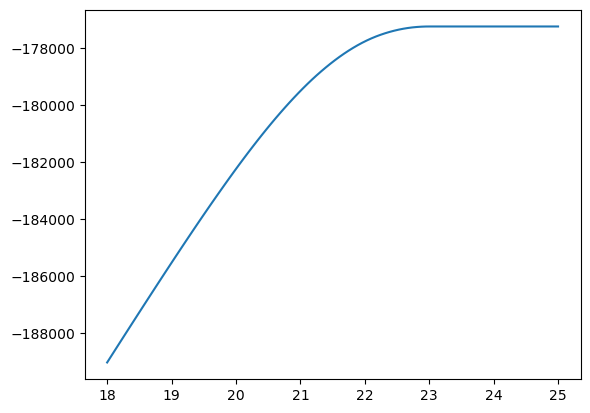

In [16]:
new_m = np.linspace(18,25,100)
new_logp = [ln_posterior1(m, 0.4034, apr_mag_r, apr_mag_r_err, k_rr, d_desi,0.0055*phi_star_shen20,0.1536*L_star_shen20,0.6571*alpha_shen20,0.7778*beta_shen20,0.1) for m in new_m]
#logp1 = ln_posterior1(18, 0.02, 1.6, apr_mag_r, k_rr, d_desi,1e-7,0.014)
plt.plot(new_m,new_logp)

In [17]:
'''
import numpy as np

# Define ranges to test
m0_values = [10, 15, 19]
b_values = [0.01, 0.1, 1]
x_values = [1.4, 1.6, 1.8]

# Loop over combinations
for m0 in m0_values:
    for b in b_values:
        for x in x_values:
            logp = ln_posterior(m0, b, x, apr_mag_r, k_rr, d_desi, 0.014)
            logp1 = ln_posterior1(m0, b, x, apr_mag_r, k_rr, d_desi, 0.014)
            print(f"m0={m0}, b={b}, x={x} -> logp={logp:.4f}, logp1={logp1:.4f}, diff={logp1 - logp:.4f}")
'''

'\nimport numpy as np\n\n# Define ranges to test\nm0_values = [10, 15, 19]\nb_values = [0.01, 0.1, 1]\nx_values = [1.4, 1.6, 1.8]\n\n# Loop over combinations\nfor m0 in m0_values:\n    for b in b_values:\n        for x in x_values:\n            logp = ln_posterior(m0, b, x, apr_mag_r, k_rr, d_desi, 0.014)\n            logp1 = ln_posterior1(m0, b, x, apr_mag_r, k_rr, d_desi, 0.014)\n            print(f"m0={m0}, b={b}, x={x} -> logp={logp:.4f}, logp1={logp1:.4f}, diff={logp1 - logp:.4f}")\n'

In [18]:
rng_key = random.PRNGKey(0)
# Sampler configuration
num_warmup, num_samples = 20000, 20000
i_start = 0
#i_end = i_start+100
# Initialize batch parameters for the entire dataset

init_params = {
    'x': 1.5 * jnp.ones((1,)),  
    'm0': 18 * jnp.ones((1,)),
    'b': 0.5 * jnp.ones((1,)),
}

# Set up the NUTS sampler
kernel = NUTS(model, target_accept_prob=0.8)
#kernel = HMC(model)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=1, jit_model_args=True, progress_bar=True)

# Run the sampler over thswwe entire dataset
#mcmc.run(rng_key, apr_mag_g, apr_mag_g_err, k_gg, apr_mag_r, apr_mag_r_err, k_rr, d,z, 22.5, init_params=init_params)
mcmc.run(rng_key, apr_mag_r,apr_mag_r_err,k_rr,d_desi)
# Get samples
samples = mcmc.get_samples()
# Optionally, process or save your samples
print(samples)

sample: 100%|██████████| 40000/40000 [18:28<00:00, 36.07it/s, 55 steps of size 4.94e-02. acc. prob=0.90]    


{'alpha': Array([-1.182983  , -1.18668826, -1.16851895, ..., -1.10378999,
       -1.10321264, -1.14445608], dtype=float64), 'b': Array([0.54083789, 0.54635422, 0.54490152, ..., 0.47805829, 0.46891084,
       0.45699408], dtype=float64), 'beta': Array([-3.07977197, -3.09779788, -3.08073647, ..., -2.79678169,
       -2.874498  , -2.97991794], dtype=float64), 'd': Array([-5.49620331, -5.4912361 , -5.48419127, ..., -5.40668967,
       -5.42561737, -5.45685593], dtype=float64), 'e': Array([46.07007337, 46.06079469, 46.06664683, ..., 45.95941346,
       46.00293829, 46.04064151], dtype=float64), 'm0': Array([21.99822561, 21.97025395, 21.96855602, ..., 22.02378632,
       22.04432261, 21.91107535], dtype=float64)}


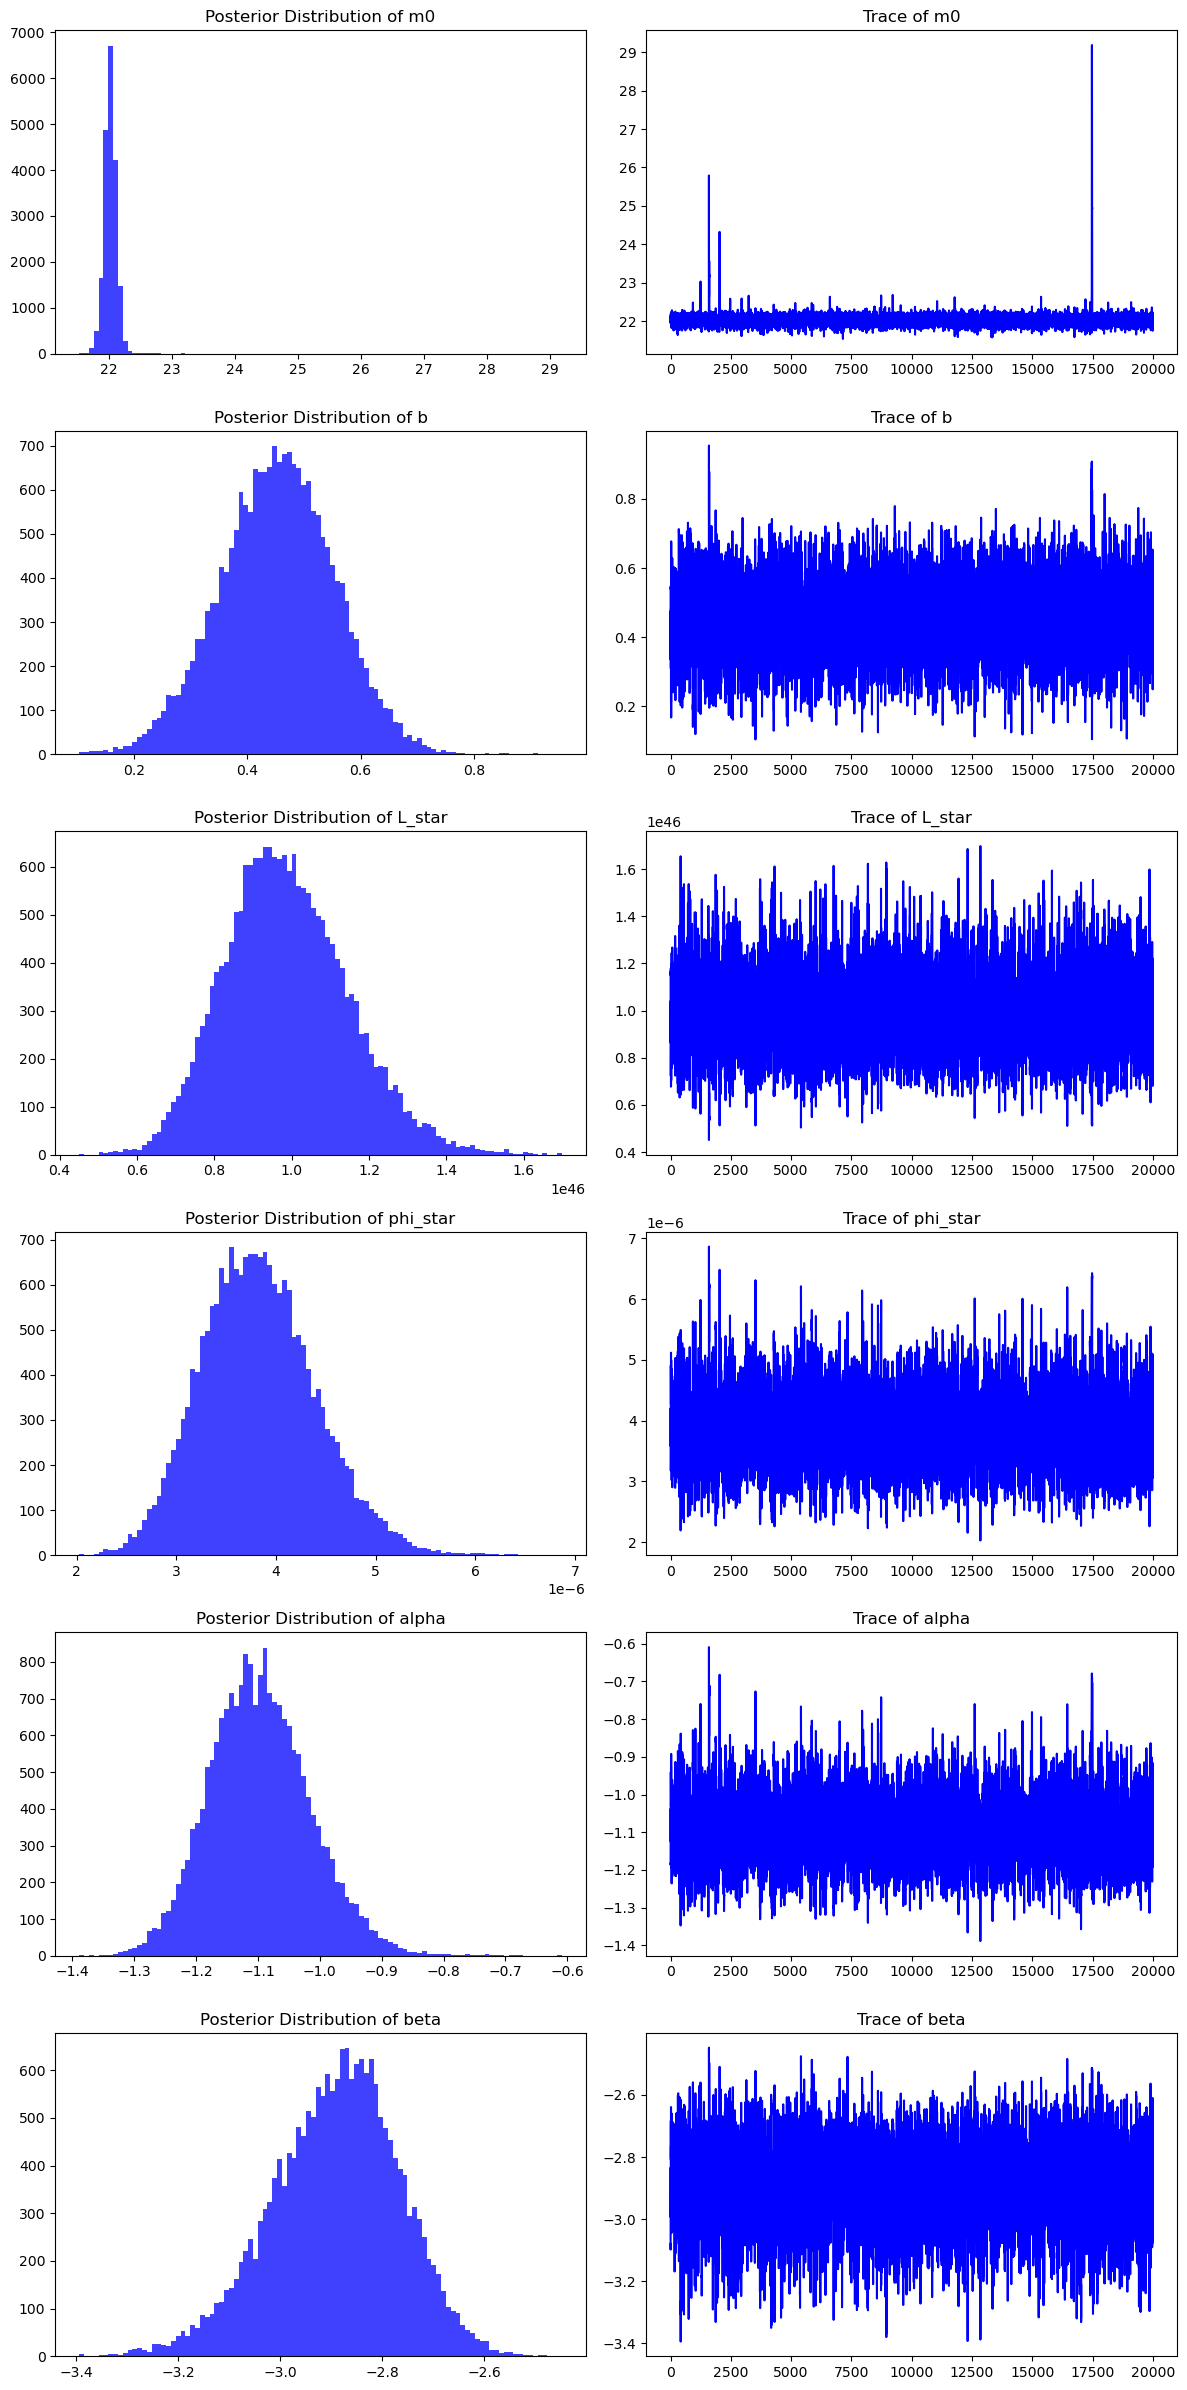

In [19]:
# Extract the chains and parameters
samples = mcmc.get_samples()
#x = samples['x']
m0 = samples['m0']
#c = samples['c']
d = samples['d']
e = samples['e']
alpha = samples['alpha']
beta = samples['beta']
#phi_star = samples['phi_star']
b = samples['b']
#b = np.exp(c)/m0
#c = 10**(b*m0)
#b = c/m0
phi_star = 10**d
L_star = 10**e
# Creating a figure to hold the subplots
fig, axs = plt.subplots(6, 2, figsize=(12, 24))  

# Helper function to plot histograms and traces
def plot_param(ax, data, title):
    ax[0].hist(data, bins=100, alpha=0.75, color='blue')
    ax[0].set_title(f'Posterior Distribution of {title}')
    ax[1].plot(data, color='blue')
    ax[1].set_title(f'Trace of {title}')

# Plotting each parameter
plot_param(axs[0], m0, 'm0')
plot_param(axs[1], b, 'b')
#plot_param(axs[2],a,'a')
#plot_param(axs[2],b,'b')
#plot_param(axs[2],c,'c')
plot_param(axs[2],L_star,'L_star')
plot_param(axs[3],phi_star,'phi_star')
plot_param(axs[4],alpha,'alpha')
plot_param(axs[5],beta,'beta')



# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

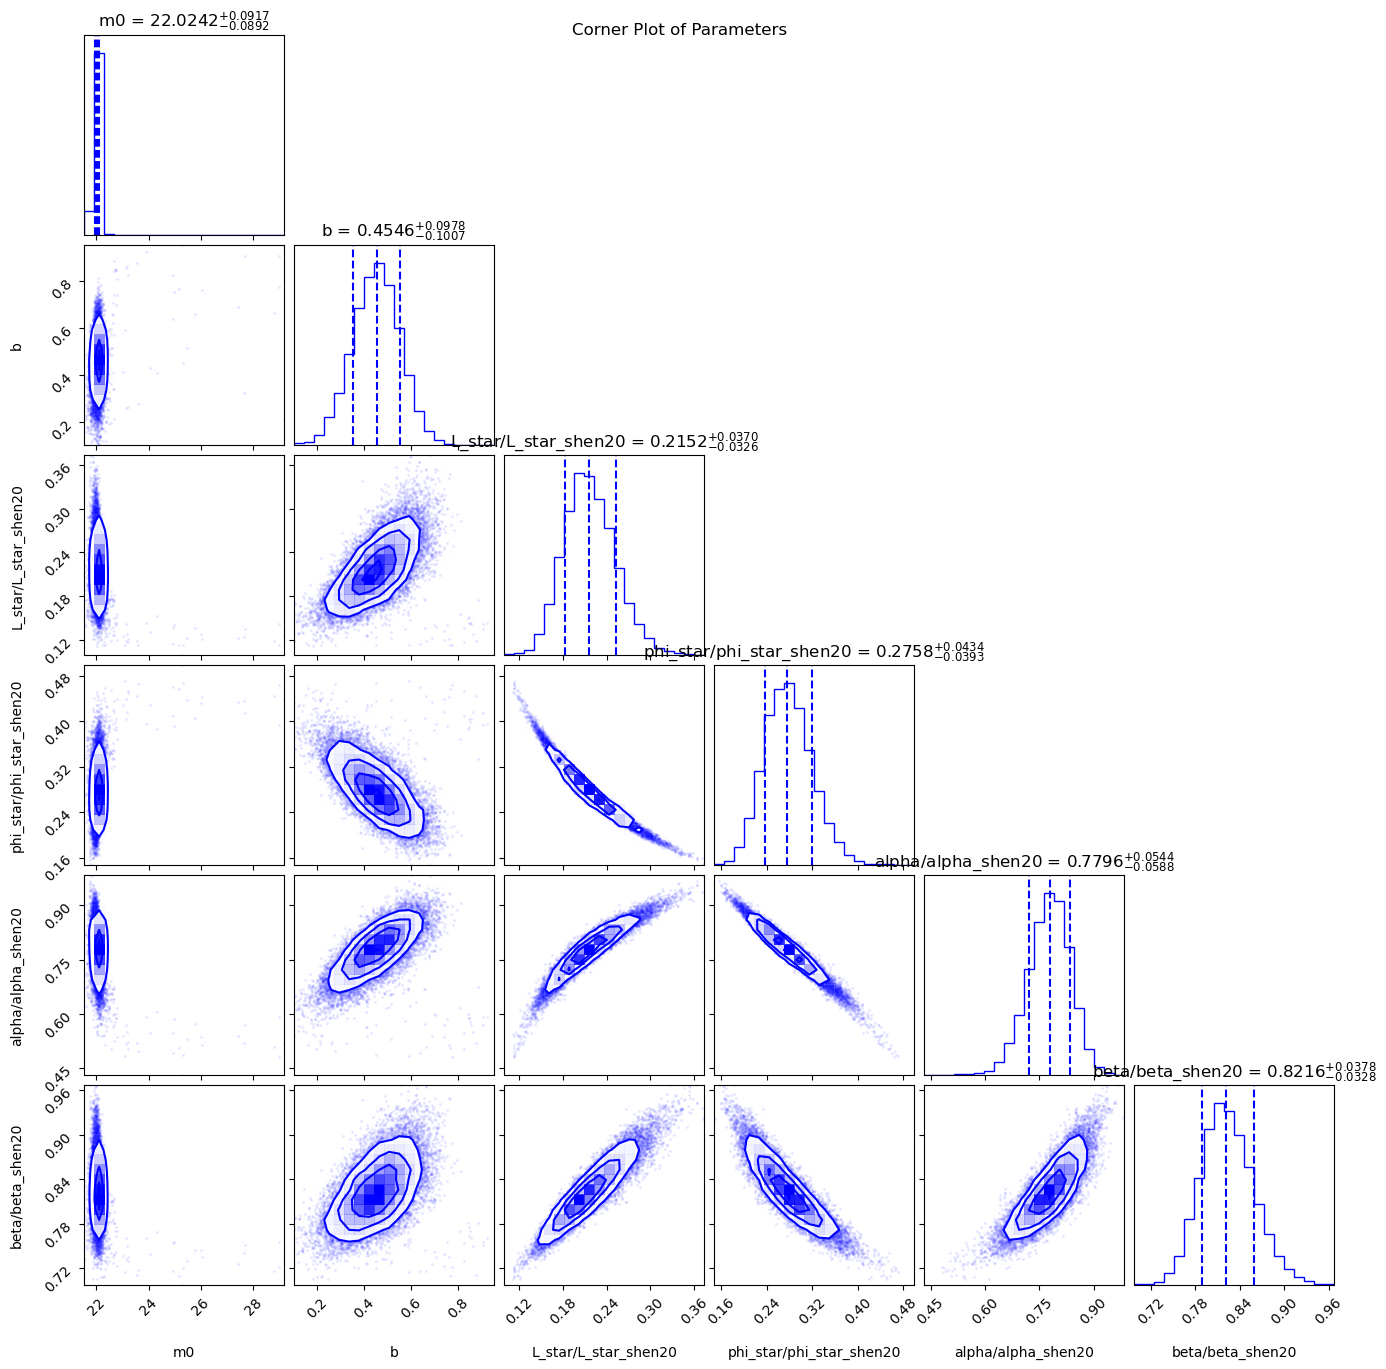

In [20]:
import corner
# Extract samples for plotting
#samples = np.vstack((x, m0)).T
samples = np.vstack((m0,b,L_star/L_star_shen20,phi_star/phi_star_shen20,alpha/alpha_shen20,beta/beta_shen20)).T
# Create a corner plot
fig = corner.corner(samples, labels=['m0','b','L_star/L_star_shen20','phi_star/phi_star_shen20','alpha/alpha_shen20','beta/beta_shen20'], 
                    show_titles=True,quantiles=[0.16, 0.5, 0.84],
                       plot_contours=True, color='blue', title_kwargs={"fontsize": 12},title_fmt=".4f")

fig.suptitle('Corner Plot of Parameters')
fig.show()

In [21]:
Planck18.comoving_volume(1)

<Quantity 1.64002856e+11 Mpc3>

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'd'}>, <Axes: title={'center': 'd'}>],
       [<Axes: title={'center': 'e'}>, <Axes: title={'center': 'e'}>],
       [<Axes: title={'center': 'm0'}>, <Axes: title={'center': 'm0'}>]],
      dtype=object)

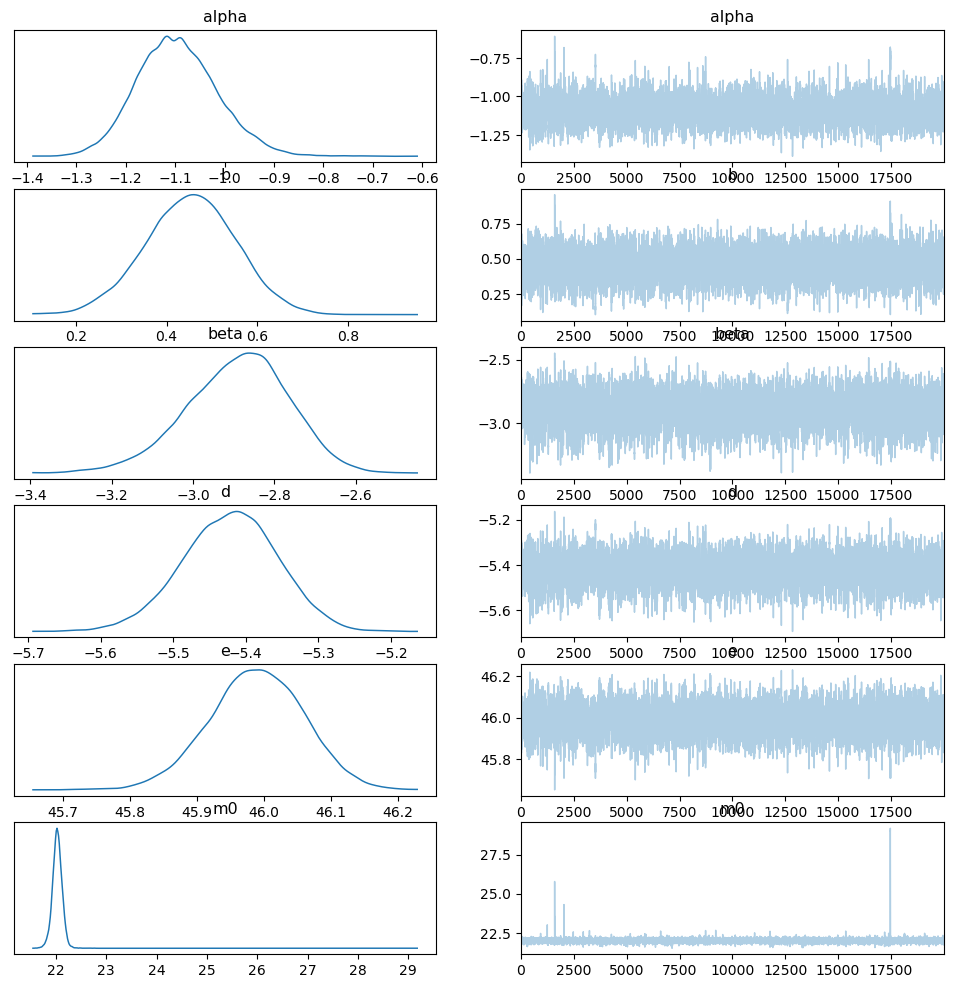

In [22]:
import arviz as az
az.plot_trace(mcmc)